In [31]:
import os
import sys
import pyaudio
import numpy as np
import scipy as sp
import scipy.io.wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## 音を数式で表現

音を時間の関数として数式で表現する。音が伝搬しているときは、ある位置における圧力が時間とともに変化する。その位置に耳があれば、時間とともに鼓膜が押されたり、引かれたりする。これが繰り返されることで、音として聞こえる。

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_wave(time, amplitude, xtitle='Time[s]', ytitle='Amplitude[arb.]', hold=False, color='blue', marker=',', legend='', linestyle='-', stem=False):
    """
    波形プロット
    @Param time         : 時刻の離散データ
    @Param amplitude    : 時刻データに対応する瞬時振幅値
    @Param xtitle       : 横軸ラベル
    @Param ytitle       : 縦軸ラベル
    @Param hold         : False -> 描画, True -> データ保持
    @Param color        : グラフの色
    @Param marker       : マーカの種類
    @Param legend       : 凡例の文字列
    @Param linestyle    : 線の種類
    @Param stem         : False -> 折れ線グラフ, True -> ○付き棒グラフ
    """
    if (len(time) == 0):
        time = range(len(amplitude))
        if (xtitle == 'Time[s]'):
            xtitle = 'Time[point]'

    if (marker != ','):
        linestyle = ''

    if (stem == False):
        plt.plot(time, amplitude, color=color, marker=marker, linestyle=linestyle, label=legend)
    else:
        plt.stem(time, amplitude, label=legend, use_line_collection = True)

    if (legend != ''):
        plt.legend()

    if (hold == False):
        plt.xlabel(xtitle)
        plt.ylabel(ytitle)
        plt.show()

100[Hz]のcos波を0.1[ms]間隔でプロットする。

$f(t) = A\cos(2\pi{ft} + \theta)$

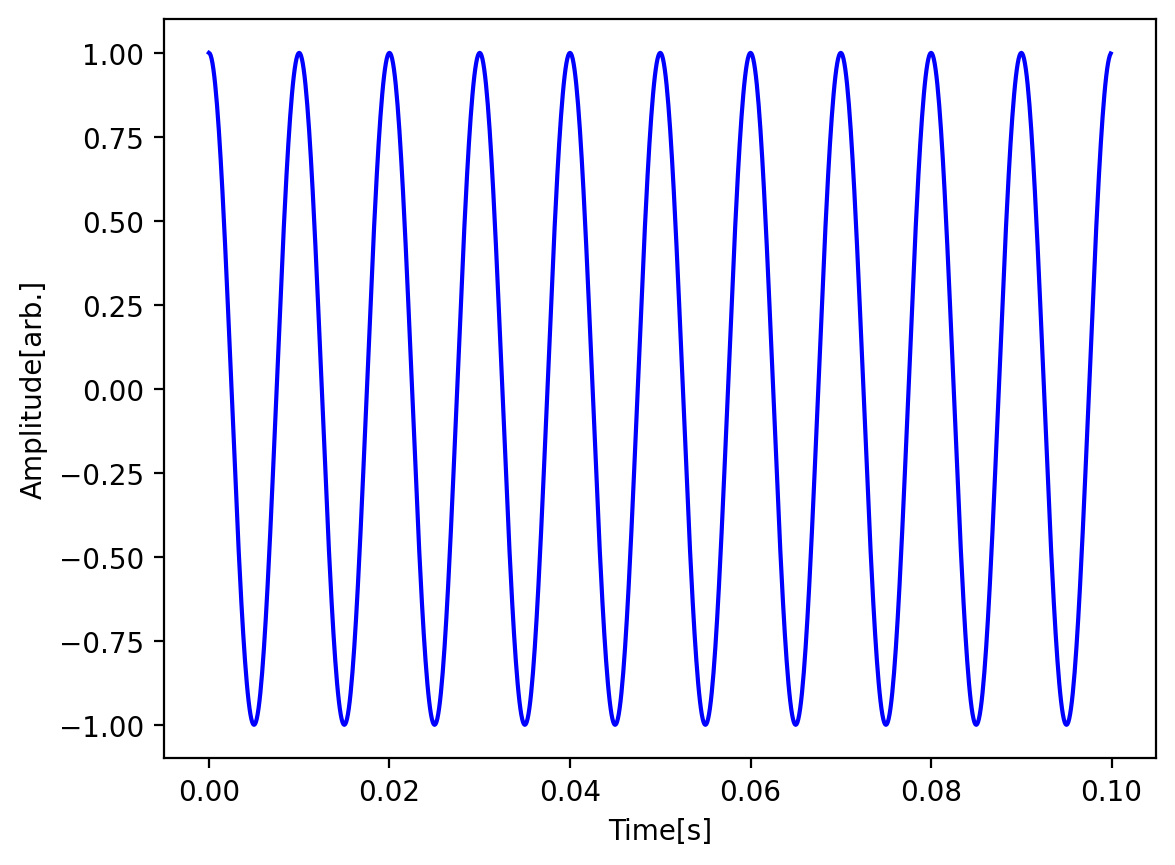

In [33]:
f = 100                         # 周波数
t = np.arange(0, 0.1, 0.1e-3)   # 0~0.1[s]の時間配列(0.1[ms]刻み)
sampled = np.cos(2*np.pi*f*t)
plot_wave(t, sampled)

振幅が2、周波数が10[Hz]、位相のずれがない波形と位相が$\pi/2$進んだ波形、遅れた波形をプロットしてみる。

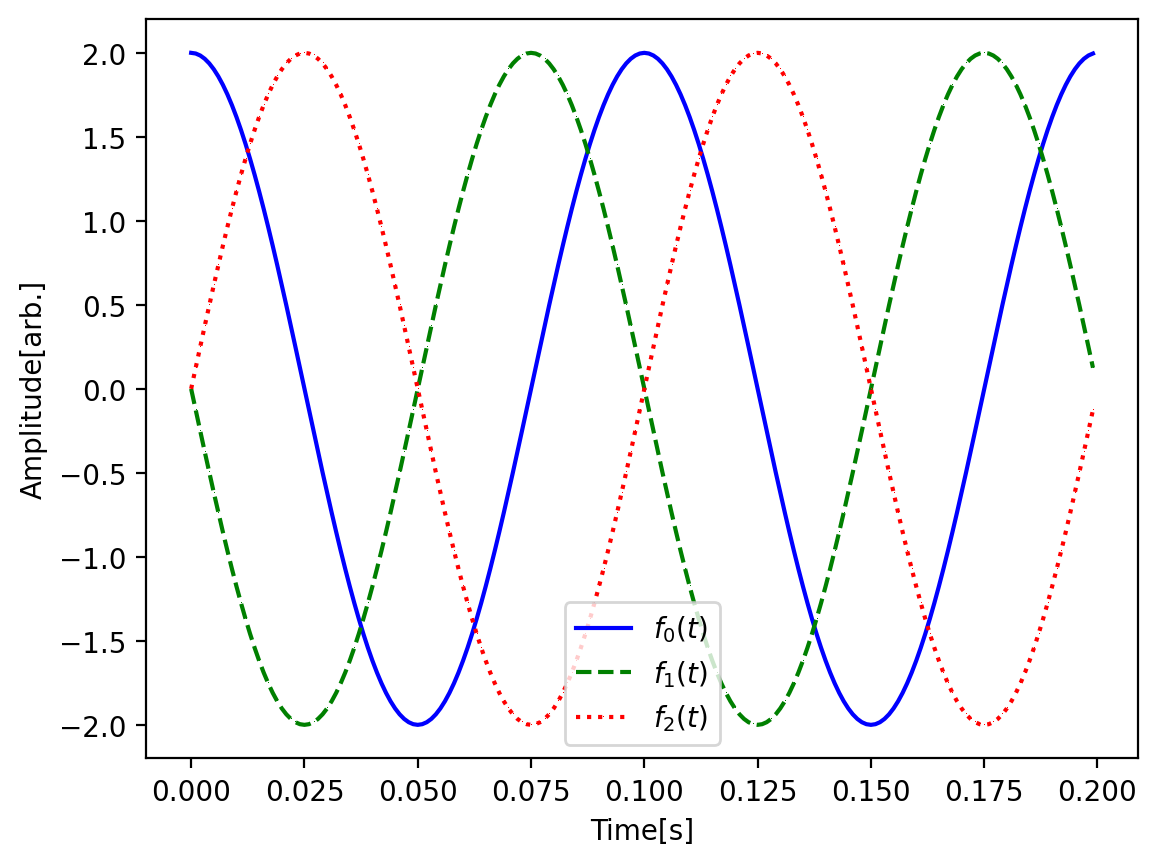

In [34]:
f = 10
A = 2
theta = np.pi / 2
t = np.arange(0, 0.2, 1e-3)
f0 = A*np.cos(2*np.pi*f*t)
f1 = A*np.cos(2*np.pi*f*t+theta)
f2 = A*np.cos(2*np.pi*f*t-theta)
plot_wave(t, f0, hold = True,  color = 'b', linestyle = '-',  legend = '$f_0(t)$')
plot_wave(t, f1, hold = True,  color = 'g', linestyle = '--', legend = '$f_1(t)$')
plot_wave(t, f2, hold = False, color = 'r', linestyle = ':',  legend = '$f_2(t)$')

$\sin$波は$\cos$波よりも$\pi/2$だけ位相が遅れた波である。また、$cos$波は$\sin$波よりも$\pi/2$だけ位相が進んだ波であり、$\cos$波に位相項がついたものとして表現できる。

$f(t) = A\cos(2\pi{ft} - \frac{\pi}{2}) = A\sin(2\pi{ft})$

空気中の音速 $c$ [m/s] は温度 $T$ [°C]により変化し、$c= 331+ 0.6 T$ で近似的に与えられる。$T=20$ のとき、$c$ を求める。

In [35]:
T = 20
c = 331 + 0.6*T
print(c)

343.0


 周波数 $f = 1000$ [Hz] のとき、波長 $\lambda$ [m] を求める。ただし、音速 $c = 340$ [m/s] （1000[Hz]は、音響学の種々の場面で基準として用いられる周波数。そこで、1000[Hz]の波の波長を瞬時に導けるようにしておくことは、回折などの音響事象を考察する際に有益。）

In [36]:
f = 1000
c = 340
wave_length = 340/1000
print(wave_length)

0.34


周波数 $f = 1000$ [Hz]の正弦波について，時間 $t$ の関数として数式で表現する(sin、cos両方)。

※位相が特に問題にならない場合は，表現としては「正弦波」と「余弦波」という区別はしない）

$
x_1(t) = \sin(2 \pi ft) \\
x_2(t) = \cos(2 \pi ft)
$

## 単一周波数のみの音(純音)を生成

CDのサンプリング周波数でもある44.1[kHz]で1000[Hz]の正弦波の波形を生成し、再生してみる。

In [37]:
f  = 1000                       # 周波数
A  = 1                          # 振幅
fs = 44100                      # サンプリング周波数
t = np.arange(0, 1, 1/fs)       # サンプリング点
sampled = A*np.cos(2*np.pi*f*t)
audio = Audio(sampled, rate=fs)
audio

最初の100個だけをプロットしてみる。

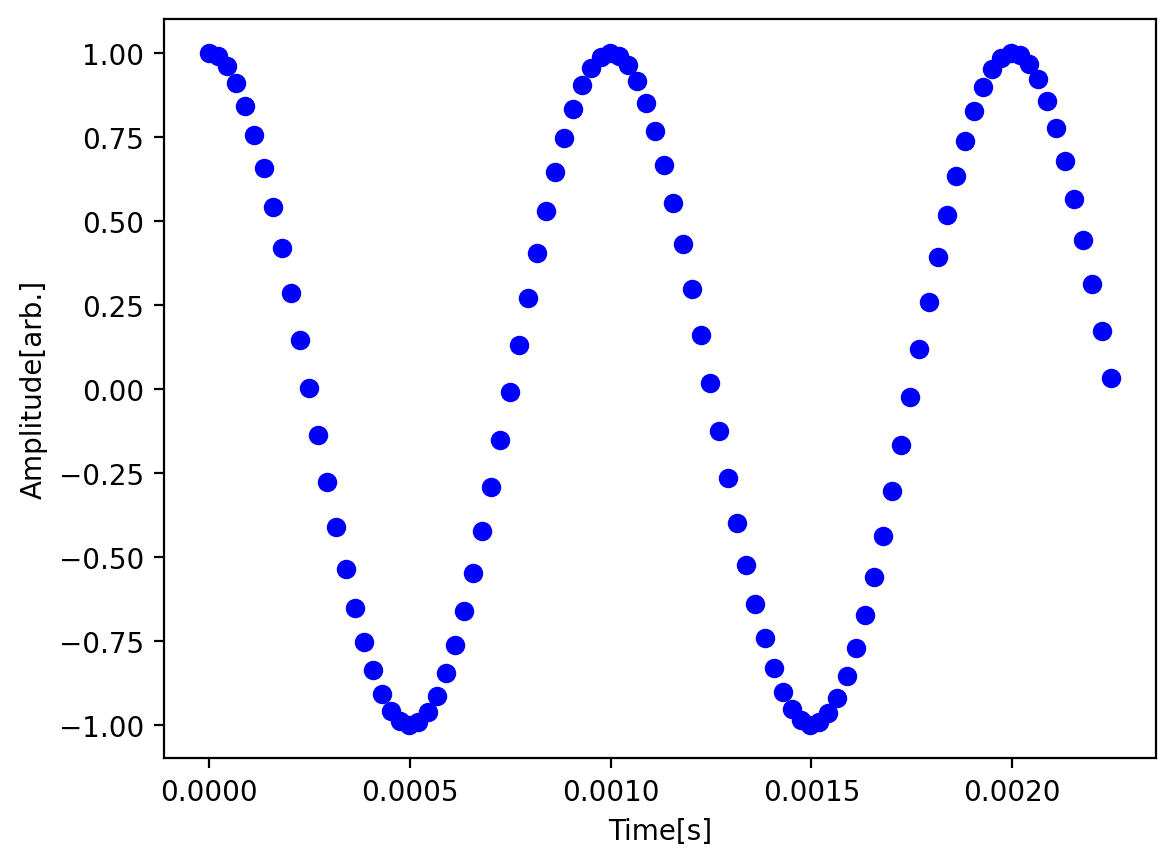

In [38]:
plot_wave(t[0:100], sampled[0:100], marker='o', color='b')

## A-D変換

A-D(analog to digital)変換は、アナログ信号に対し、標本化、量子化を行い、ディジタル信号に変換すること。マイクロホンの場合は、音圧から電圧に変換を行うことでA-D変換を行う。

サンプル波形として、周波数50[Hz}]、振幅10000の波形をプロットする。

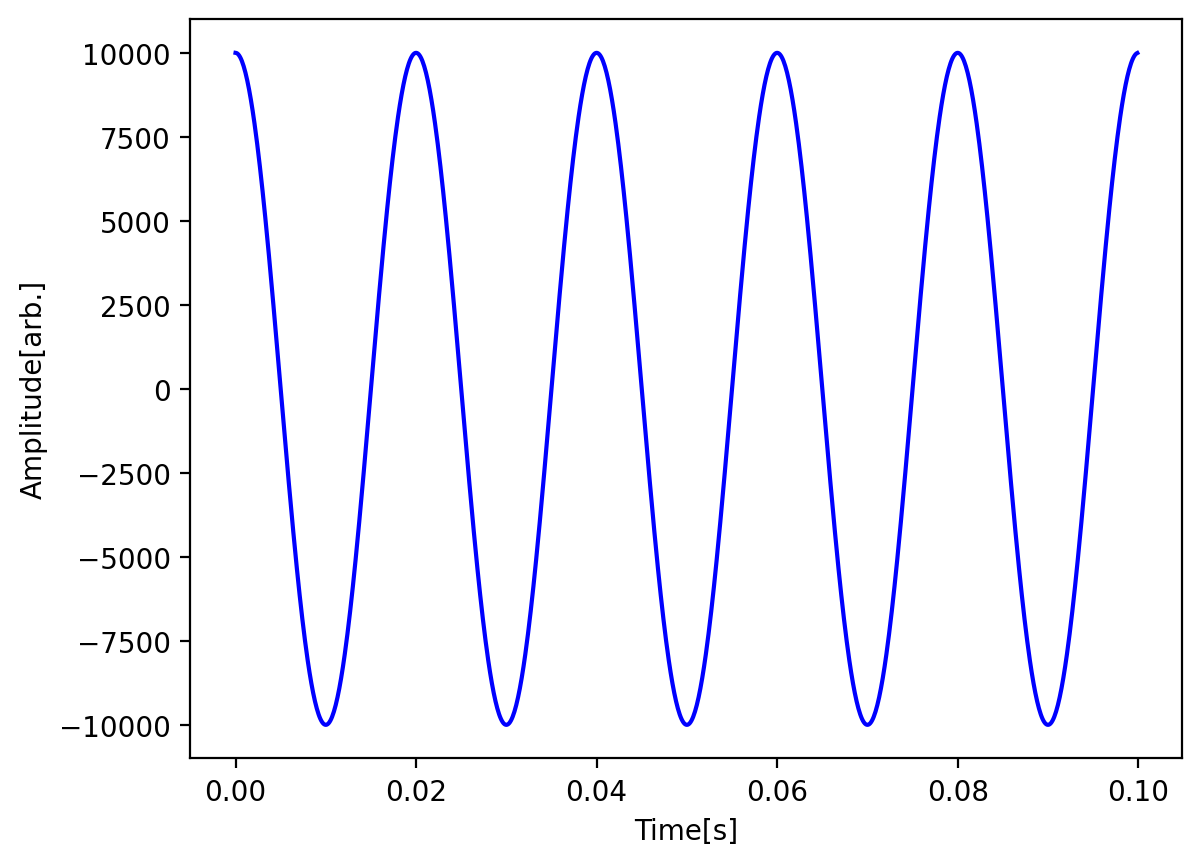

In [60]:
f = 50                          # 周波数
A = 10000                       # 振幅
t = np.arange(0, 0.1, 0.1e-3)   # サンプリング点
sample_wave = A * np.cos(2*np.pi*f*t)

plot_wave(t, sample_wave)

### 標本化

標本化は、サンプリング周期$T_s$ごとにアナログ波形の値を調べること。このとき、サンプリング周波数は$f_s = 1 / T_s$となる。例えば、CDのサンプリング周波数は、44.1[kHz]である。標本化定理に基づけば、周波数$f$の信号を標本化するには、サンプリング周波数は、$f_s > 2f$となる必要がある。

50[Hz]のサンプル波形の2倍よりも十分高い500[Hz]で標本化してみる。

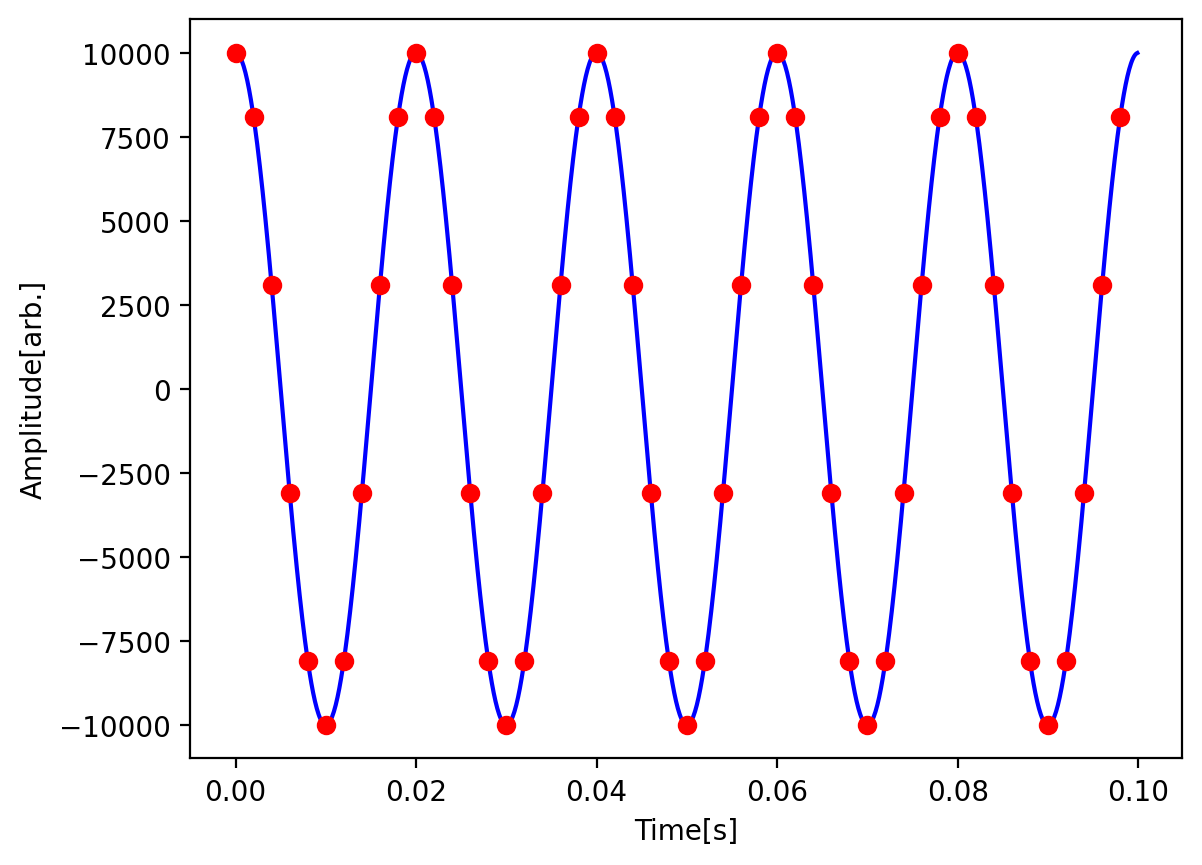

In [59]:
fs = 500                        # サンプリング周波数
dt = np.arange(0, 0.1, 1/fs)    # サンプリング周期
sampled = A*np.cos(2*np.pi*f*dt)

plot_wave(t, sample_wave, hold=True)            # 元の波形
plot_wave(dt, sampled, marker='o', color='r')   # 標本化された値

標本化定理を無視して、サンプリング周波数を90[Hz]で標本化を行ってみる。

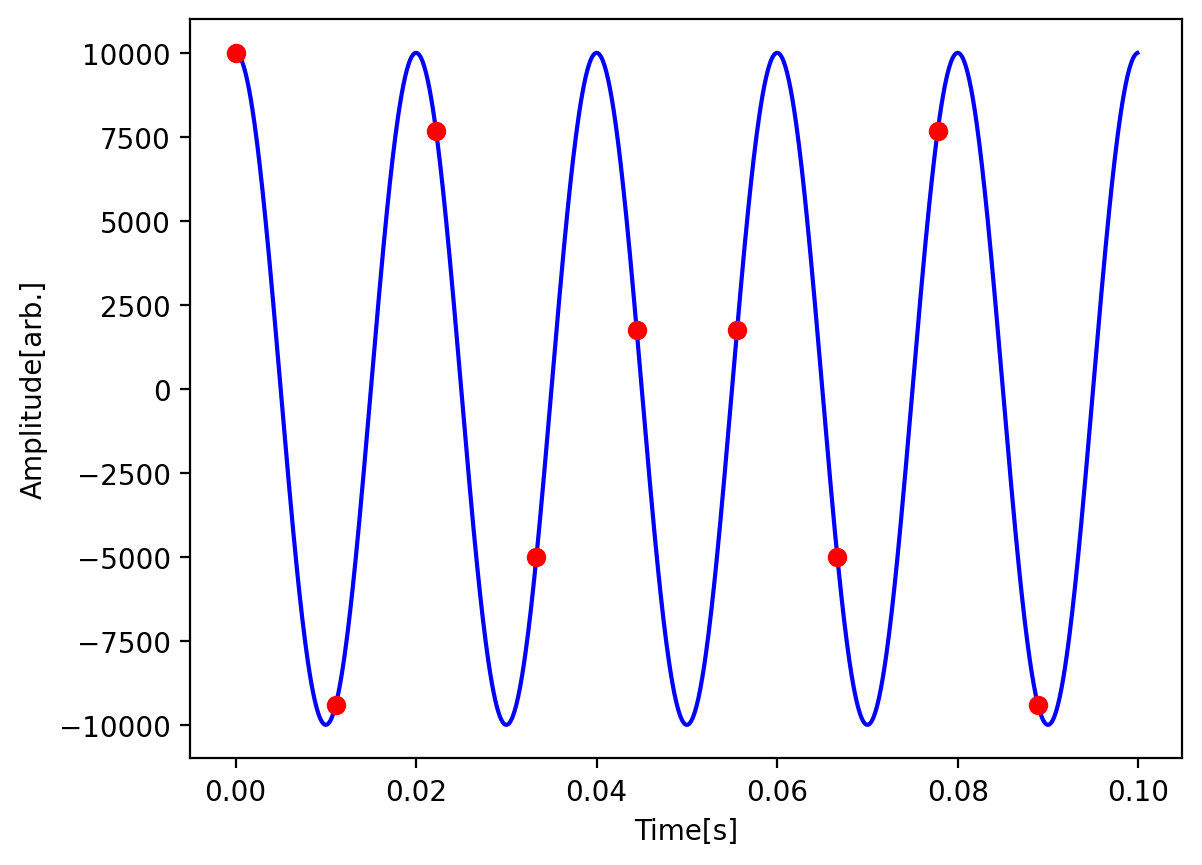

In [58]:
fs = 90                         # サンプリング周波数
dt = np.arange(0, 0.1, 1/fs)    # サンプリング周期
sampled = A*np.cos(2*np.pi*f*dt)

plot_wave(t, sample_wave, hold = True)              # 元の波形
plot_wave(dt, sampled, marker = 'o', color = 'r')   # 標本化された値

サンプリング点が元の波形の上にあるが、これらのサンプリング点は40[Hz]の別のcos波と同期してしまう。

試しに40[Hz]のcos波をプロットしてみる。

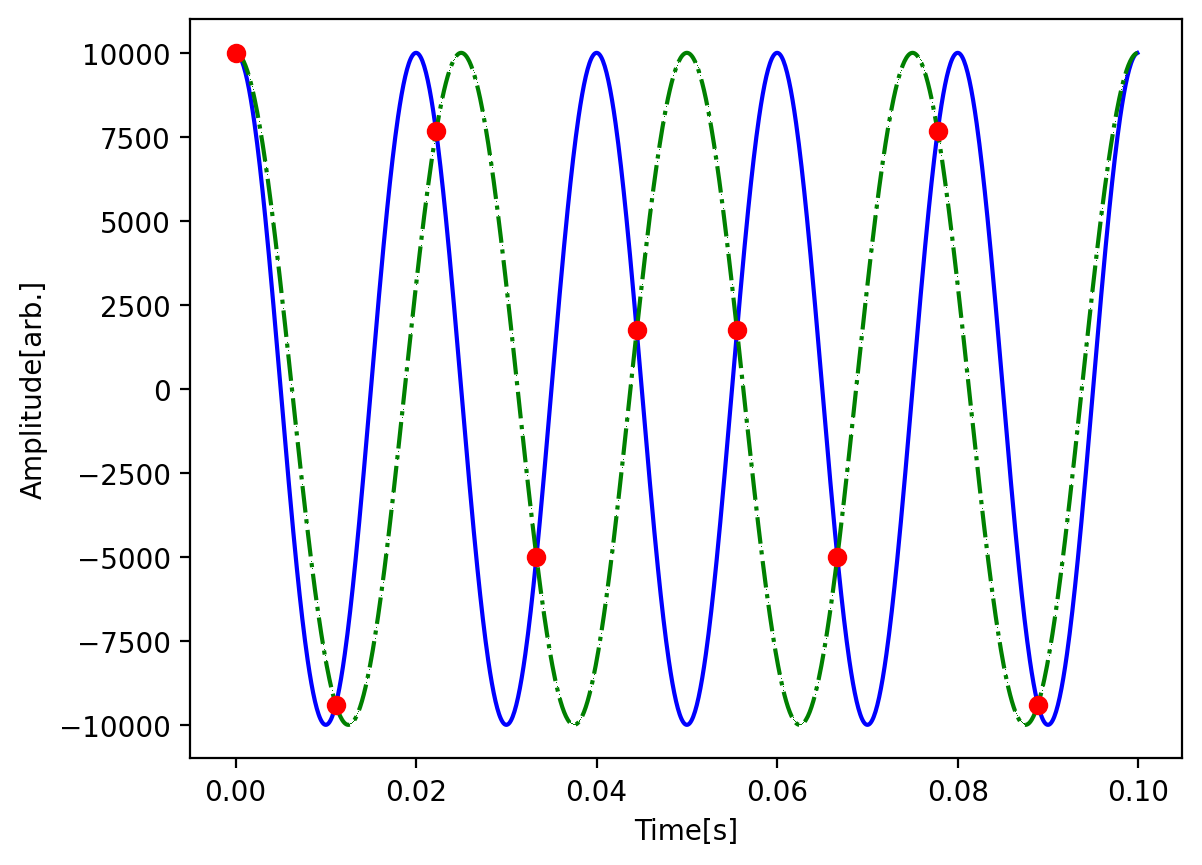

In [57]:
fw = 40                             # 意図しない周波数
fs = 90                             # サンプリング周波数
dt = np.arange(0, 0.1, 1/fs)        # サンプリング周期
sampled = A*np.cos(2*np.pi*fw*dt)   # サンプリング周期で標本化された値
fw_wave = A*np.cos(2*np.pi*fw*t)    # 意図しない周波数の波形

plot_wave(t, sample_wave, hold=True)                        # 標本化対象としたい波形
plot_wave(t, fw_wave, hold=True, color='g', linestyle='-.') # 意図しない周波数の波形
plot_wave(dt, sampled, marker='o', color='r')               # 標本化された値


上図のように、50[Hz]の波形の上にサンプリング点が乗っているが、40[Hz]の波形の上にもサンプリング点が乗っている。90[Hz]の場合、標本化定理を満たすのは45[Hz]未満の波なので、標本点は40[Hz]のcos波を表すことになっている。

以上のことからも、標本化定理を満たす条件が、正しく標本化できる周波数$f$は、$f < fs/2$を満たす$f$に限られることがわかる。

### 量子化

量子化は、標本化によって時間軸上で離散化(ディジタル化)